In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import time
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from copy import deepcopy
import numpy as np
from numpy import dot, zeros, eye, outer
from numpy.random import multivariate_normal


In [2]:
class Lecture:

    def __init__(self, filename):
        
        self.tab_lorenz_x=[];
        self.tab_lorenz_y=[];
        self.tab_lorenz_z=[];
        self.tab_temps=[]
        f = open(filename, "r")
        line = f.readline().split()
        while line:
            self.tab_lorenz_x.append(float(line[1]))
            self.tab_lorenz_y.append(float(line[2]))
            self.tab_lorenz_z.append(float(line[3]))
            self.tab_temps.append(float(line[0]))
            line = f.readline().split()
            
        f.close()

class Lecture2:

    def __init__(self, filename):
        
        self.tab_lorenz=[];
        self.tab_temps=[]
        f = open(filename, "r")
        line = f.readline().split()
        while line:
            self.tab_lorenz.append([float(line[1]),float(line[2]),float(line[3])])
            self.tab_temps.append(float(line[0]))
            line = f.readline().split()
            
        f.close()

In [3]:
def plot(lorenz1,lorenz2,tab_temps,tab_x_y_z):
    fig=plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.plot(lorenz1[3],lorenz1[0],label="observation")
    ax1.plot(lorenz2[3],lorenz2[0],label="Model")
    ax1.plot(tab_temps,tab_x_y_z[:,0],label="Analized state")
    plt.xlabel("t")
    plt.ylabel("x")
    ax1.legend(loc='upper right')
    
    ax2 = fig.add_subplot(1,3,2)
    ax2.plot(lorenz1[3],lorenz1[1],label="observation")
    ax2.plot(lorenz2[3],lorenz2[1],label="Model ")
    ax2.plot(tab_temps,tab_x_y_z[:,1],label="Analized state")
    plt.xlabel("t")
    plt.ylabel("y")
    ax1.legend(loc='upper right')
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.plot(lorenz1[3],lorenz1[2],label="observation ")
    ax3.plot(lorenz2[3],lorenz2[2],label="Model")
    ax3.plot(tab_temps,tab_x_y_z[:,2],label="Analized state")
    plt.xlabel("t")
    plt.ylabel("z")
    ax1.legend(loc='upper right')

In [4]:

def f(t_n,X_n,σ, b, r):
    (x,y,z)=X_n
    
    f_1 = σ*(y-x)
    f_2 = x*(r-z)-y
    f_3 = x*y-b*z
    return np.array([f_1,f_2,f_3])

def RK4_Lorenz(γ,X0,N,T): 
    (σ,b,r)=γ
    dt=T/N
    X = np.zeros( (N+1, len(X0)) )
    T_tab=np.zeros(N+1)
    X[0] = X0
    T_tab[0]=0
    
    t=0. #=t_0
    for n in range(1,N+1):
        
        K1=f(t, X[n-1],σ,b,r)
        K2=f(t+dt/2., X[n-1] + 1./2. * K1 * dt,σ,b,r)
        K3=f(t+dt/2., X[n-1] + 1./2. * K2 * dt,σ,b,r)
        K4=f(t+dt, X[n-1]+ K3 * dt,σ,b,r)
        T_tab[n]=t+dt
        X[n]=X[n-1]+ dt/6.* (K1+2.*K2+2.*K3+K4)
        t+=dt
        
    return X[:,0],X[:,1],X[:,2],T_tab


In [5]:
class EnsembleKalmanFilter2(object):
    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None]*self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        self.initialize(x, P)
        self.Q = eye(dim_x)       # process uncertainty
        self.R = eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)

    def initialize(self, x, P):

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def update(self, z, R=None):
        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = zeros((N, dim_z))


        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = 0
        for sigma in sigmas_h:
            s = sigma - z_mean
            P_zz += outer(s, s)
        P_zz = P_zz / (N-1) + R
        self.S = P_zz
        self.SI = self.inv(self.S)


        P_xz = 0
        for i in range(N):
            P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
        P_xz /= N-1

        self.K = dot(P_xz, self.inv(P_zz))

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - dot(dot(self.K, P_zz), self.K.T)
        

        
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
        


    def predict(self):
        N = self.N
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)
        e = multivariate_normal(self._mean, self.Q, N)
        
        self.sigmas += e

        P = 0
        for s in self.sigmas:
            sx = s - self.x
            P += outer(sx, sx)

        self.P = P / (N-1)
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)


   

In [6]:
def assimilation_donnée2(x,read_sensor,P,Q,R,T,dimz,dt,N,nb_echantillon,hx,fx,γ):
    f = EnsembleKalmanFilter2(x=x, P=P, dim_z=dimz, dt=dt, N=nb_echantillon,hx=hx, fx=lambda x,dt:fx(x,t,dt,γ))
    f.R = R # matrice de cov associer a la mesure
    f.Q =Q   #bruit blanc  centree en 0
    t=0
    index=N
    tab_etat=[]
    tab_temps=[]
    tab_cov=[]
    tab_etat.append(f.x)
    tab_temps.append(t)
    tab_cov.append(f.P_post.diagonal())
    while (t<(T)):#
        z = read_sensor(index)
        f.predict()
        f.update(z)
        diag_cov=f.P_post.diagonal()
        tab_cov.append(diag_cov)
        index+=N
        t=t+dt
        tab_etat.append(f.x)
        tab_temps.append(t)
    return(np.array(tab_etat),np.array(tab_temps),np.array(tab_cov))





In [7]:
γ1=(12.,6.,12.) #(σ,b,r)
γ2=(10.,6.,10.) #(σ,b,r)
X0=(-10.,10.,25.) #(x0,y0,z0)
T=4
N=int(T/0.1)

In [8]:
lorenz1=RK4_Lorenz(γ1,X0,N,T)

In [9]:
N=int(T/0.1)

In [10]:
lorenz2=RK4_Lorenz(γ2,X0,N,T)
print(lorenz2)

(array([-10.        ,   4.23708333,   8.00993241,   7.90907243,
         6.72839677,   6.06299902,   6.19858305,   6.86819568,
         7.63608687,   8.03417048,   7.87047514,   7.39956583,
         7.02295647,   6.94293957,   7.12089183,   7.38790482,
         7.56210749,   7.55579924,   7.41878634,   7.27371888,
         7.21311802,   7.25082786,   7.33817321,   7.40912483,
         7.42380628,   7.3875034 ,   7.33638127,   7.30618764,
         7.3099755 ,   7.33646921,   7.36344525,   7.3740853 ,
         7.3660247 ,   7.3491729 ,   7.33630436,   7.33433383,
         7.34161558,   7.35122944,   7.35661749,   7.35554392,
         7.35036565]), array([10.        , 11.83511875,  9.4879156 ,  6.89345442,  5.68239143,
        5.82284849,  6.6640158 ,  7.67230104,  8.29207319,  8.14522884,
        7.47934696,  6.91626524,  6.78317922,  7.01336495,  7.37753751,
        7.63562393,  7.64947008,  7.46550235,  7.25590922,  7.1611297 ,
        7.20580838,  7.32493328,  7.42783654,  7.45516813,

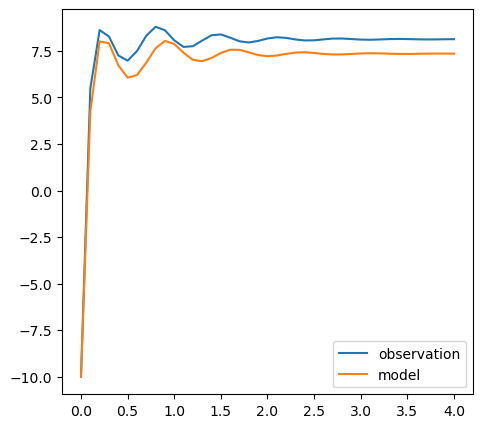

In [11]:
fig=plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,2)
ax1.plot(lorenz1[3],lorenz1[0],label="observation")
ax1.plot(lorenz2[3],lorenz2[0],label="model")
ax1.legend()

In [12]:

γ=(12.,6.,12.)  #(σ,b,r)
N=1
T=4

x = np.array([-10.,10.,25.])#(x0,y0,z0)
dt= N*0.1
P = np.eye(3) * 2.

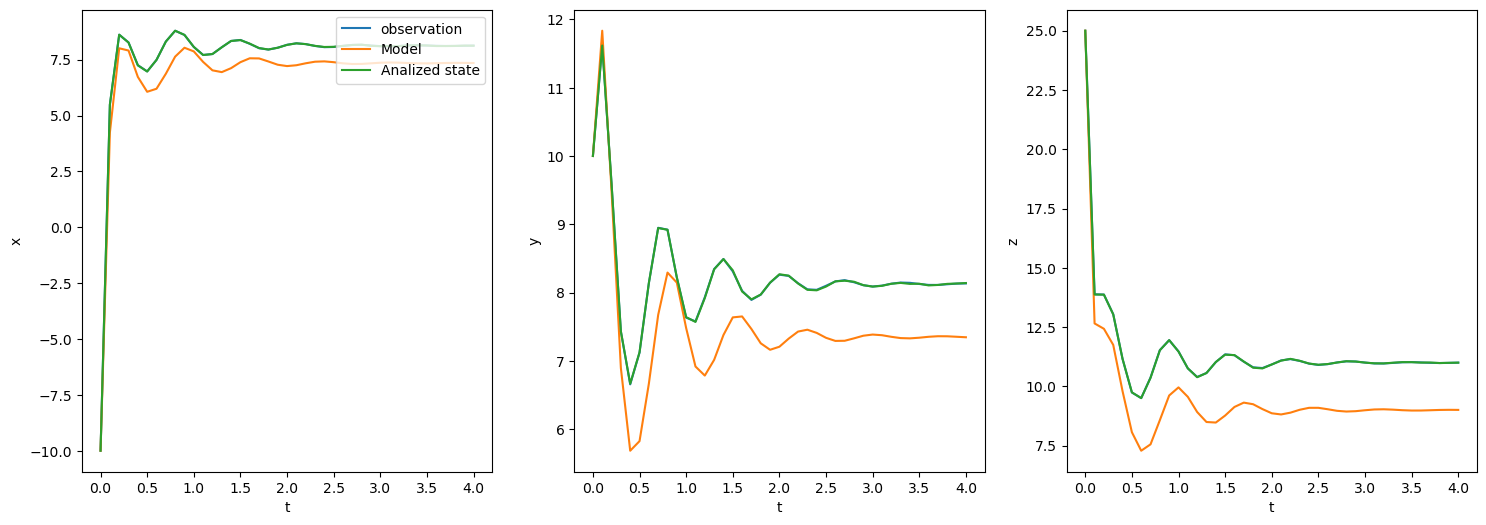

In [13]:
def fx(x,t, dt,γ):
    def f(t_n,X_n,γ): 
        (x,y,z)=X_n
        f_1 = γ[0]*(y-x)
        f_2 = x*(γ[2]-z)-y
        f_3 = x*y-γ[1]*z
        return np.array([f_1,f_2,f_3])
    K1=f(t, x,γ)
    K2=f(t+dt/2., x + 1./2. * K1 * dt,γ)
    K3=f(t+dt/2., x + 1./2. * K2 * dt,γ)
    K4=f(t+dt, x+ K3 * dt,γ)
    X_next=x+ dt/6.* (K1+2.*K2+2.*K3+K4)
    return X_next

def hx_ex(x):
   return x

P=np.eye(3)*0.1
Q=np.eye(3)*0.1
R= np.eye(3)*0.001  
dt= N*0.1

def read_sensor_ex(index):
    return np.array([lorenz1[0][index],lorenz1[1][index],lorenz1[2][index]])

tab_model,tab_temps_model,tab_cov_model=assimilation_donnée2(x,read_sensor_ex,P,Q,R,T,3,dt,N,20,hx_ex,fx,γ)
plot(lorenz1,lorenz2,tab_temps_model,tab_model)

In [14]:
Lorenz1=Lecture("plotlorenz1.csv")
Lorenz2=Lecture("plotlorenz2.csv")
Lorenz3=Lecture2("plotetat.csv")

In [15]:
print(Lorenz1)

In [16]:
print(Lorenz2)

In [17]:
print(Lorenz3)

In [18]:
lorenz1=(np.array(Lorenz1.tab_lorenz_x),np.array(Lorenz1.tab_lorenz_y),np.array(Lorenz1.tab_lorenz_z),np.array(Lorenz1.tab_temps))
lorenz2=(np.array(Lorenz2.tab_lorenz_x),np.array(Lorenz2.tab_lorenz_y),np.array(Lorenz2.tab_lorenz_z),np.array(Lorenz2.tab_temps))
tab_etat=np.array(Lorenz3.tab_lorenz)
tab_temps=np.array(Lorenz3.tab_temps)


In [19]:
print(lorenz1)

(array([-10.     ,   5.4842 ,   8.61793,   8.27137,   7.25422,   6.97381,
         7.48874,   8.31138,   8.79409,   8.60648,   8.06793,   7.71127,
         7.75182,   8.05585,   8.33754,   8.38257,   8.21043,   8.01365,
         7.95116,   8.03526,   8.16618,   8.23221,   8.19733,   8.11391,
         8.05919,   8.06794,   8.11755,   8.15985,   8.1639 ,   8.13598,
         8.10577,   8.09719,   8.11144,   8.13186,   8.14116,   8.13489,
         8.12178,   8.11368,   8.11559,   8.12355,   8.1299 ]), array([10.     , 11.6317 ,  9.58947,  7.42995,  6.65459,  7.11969,
        8.13668,  8.94842,  8.92061,  8.21974,  7.6318 ,  7.57726,
        7.93086,  8.34333,  8.49146,  8.30927,  8.02509,  7.89191,
        7.96847,  8.14329,  8.26117,  8.24337,  8.13623,  8.04669,
        8.03934,  8.0986 ,  8.16276,  8.1812 ,  8.15061,  8.10702,
        8.08752,  8.10102,  8.12889,  8.14611,  8.14198,  8.12497,
        8.11149,  8.11106,  8.12075,  8.13057,  8.1329 ]), array([25.     , 13.8824 , 13.8739 ,

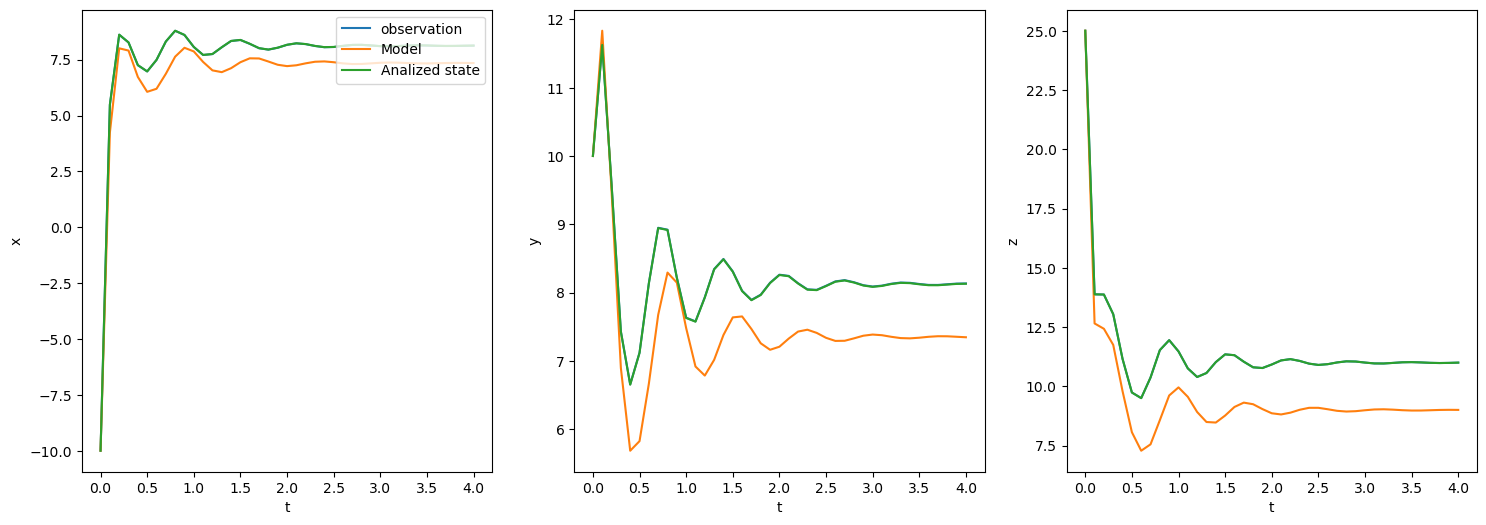

In [20]:
plot(lorenz1,lorenz2,tab_temps,tab_etat)